---
# SQL Databases Parsing And Processing

---

In [2]:
# Create Sample SQLite Database
import sqlite3
import os

os.makedirs("data/databases", exist_ok=True)
print("✅ created 'data/databases' folder, if not exists")

✅ created 'data/databases' folder, if not exists


In [4]:
# Create Sample Dtatbase
conn = sqlite3.connect('data/databases/company.db')
cursor = conn.cursor()
print("✅ created sample database as 'company.db' ")

✅ created sample database as 'company.db' 


In [16]:
# Create tables
cursor.execute('''CREATE TABLE IF NOT EXISTS employees
                  (id INTEGER PRIMARY KEY,
                   name TEXT,
                   role TEXT,
                   department TEXT,
                   salary REAL
                )'''
        )

In [8]:
print("✅ employees table has created...")

✅ employees table has created...


In [17]:
cursor.execute('''CREATE TABLE IF NOT EXISTS projects
                  ( id INTEGER PRIMARY KEY,
                    name TEXT,
                    status TEXT,
                    budget REAL,
                    lead_id INTEGER
               )'''
        )

In [10]:
print("✅ projects table has created...")

✅ projects table has created...


In [18]:
# Insert Sample Data

employees = [
    (1, 'John Doe', 'Senior Developer', 'Engineering', 95000),
    (2, 'Jane Smith', 'Data Scientist', 'Analytics', 105000),
    (3, 'Mike Johnson', 'Product Manager', 'Product', 110000),
    (4, 'Sarah Williams', 'DevOps Engineer', 'Engineering', 98000)    
]

projects = [
    (1, 'RAG Implementation', 'Active', 150000, 1),
    (2, 'Data Pipeline', 'Completed', 80000, 2),
    (3, 'Customer Portal', 'Planning', 200000, 3),
    (4, 'ML Platform', 'Active', 250000, 2)
]

In [19]:
cursor.executemany('INSERT OR REPLACE INTO employees VALUES(?,?,?,?,?)', employees
)

cursor.executemany(
    'INSERT OR REPLACE INTO projects VALUES(?,?,?,?,?)', projects
)

In [21]:
print("✅ inserted sample data into both employees and projects table")

✅ inserted sample data into both employees and projects table


In [22]:
cursor.execute("Select * from employees")

In [23]:
cursor.execute("Select * from employees")

In [24]:
conn.commit()
conn.close()

---

## Database Content Extraction

In [25]:
from langchain_community.utilities import SQLDatabase
from langchain_community.document_loaders import SQLDatabaseLoader

---

### Method 1: Using SQLDatabase Utility 👉 [Learn more](https://python.langchain.com/docs/integrations/tools/sql_database/)

### SQLDatabaseLoader 👉 [Learn more](https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.sql_database.SQLDatabaseLoader.html)

In [ ]:
from langchain_community.utilities import SQLDatabase

print("1️⃣ Using SQLDatabase Utility")

db = SQLDatabase.from_uri("sqlite:///data/databases/company.db")

# Get Database information
print(f"Tables: {db.get_usable_table_names()}")
print(f"\n Table DDL:")
print(db.get_table_info())

1️⃣ Using SQLDatabase Utility
Tables: ['employees', 'projects']

 Table DDL:

CREATE TABLE employees (
	id INTEGER, 
	name TEXT, 
	role TEXT, 
	department TEXT, 
	salary REAL, 
	PRIMARY KEY (id)
)

/*
3 rows from employees table:
id	name	role	department	salary
1	John Doe	Senior Developer	Engineering	95000.0
2	Jane Smith	Data Scientist	Analytics	105000.0
3	Mike Johnson	Product Manager	Product	110000.0
*/


CREATE TABLE projects (
	id INTEGER, 
	name TEXT, 
	status TEXT, 
	budget REAL, 
	lead_id INTEGER, 
	PRIMARY KEY (id)
)

/*
3 rows from projects table:
id	name	status	budget	lead_id
1	RAG Implementation	Active	150000.0	1
2	Data Pipeline	Completed	80000.0	2
3	Customer Portal	Planning	200000.0	3
*/


----

### Method 2: Custom SQL to Document conversion
#### **Strategry 2.1: Create documents for each table**

In [ ]:
from typing import List
from langchain_core.documents import Document

print("\n2️⃣ Custom SQL Processing")

def sql_to_documents(db_path: str) -> List[Document]:
    """Convert SQL Database To documents with context"""
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    documents = []

    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()

    for table in tables:
        table_name = table[0]

        # Get table schema
        cursor.execute(f"PRAGMA table_info({table_name});")
        columns = cursor.fetchall()
        column_names = [col[1] for col in columns]

        # Get table data
        cursor.execute(f"SELECT * FROM {table_name}")
        rows = cursor.fetchall()

        # Create table overview dcoument
        table_content = f"Table: {table_name}\n"
        table_content += f"Columns {', '.join(column_names)}\n"
        table_content += f"Total Records: {len(rows)}\n\n"

        # Add sample records
        table_content += "Sample Records:\n"
        for row in rows[:5]: # First 5 records
            record = dict(zip(column_names, row))
            table_content += f"{record}\n"

        doc = Document(
            page_content=table_content,
            metadata={
                'source': db_path,
                'table_name': table_name,
                'num_records': len(rows),
                'data_type': 'sql_table'
            }
        )

        documents.append(doc)

    conn.close()
    return documents


2️⃣ Custom SQL Processing


In [33]:
sql_to_documents("data/databases/company.db")

[Document(metadata={'source': 'data/databases/company.db', 'table_name': 'employees', 'num_records': 4, 'data_type': 'sql_table'}, page_content="Table: employees\nColumns id, name, role, department, salary\nTotal Records: 4\n\nSample Records:\n{'id': 1, 'name': 'John Doe', 'role': 'Senior Developer', 'department': 'Engineering', 'salary': 95000.0}\n{'id': 2, 'name': 'Jane Smith', 'role': 'Data Scientist', 'department': 'Analytics', 'salary': 105000.0}\n{'id': 3, 'name': 'Mike Johnson', 'role': 'Product Manager', 'department': 'Product', 'salary': 110000.0}\n{'id': 4, 'name': 'Sarah Williams', 'role': 'DevOps Engineer', 'department': 'Engineering', 'salary': 98000.0}\n"),
 Document(metadata={'source': 'data/databases/company.db', 'table_name': 'projects', 'num_records': 4, 'data_type': 'sql_table'}, page_content="Table: projects\nColumns id, name, status, budget, lead_id\nTotal Records: 4\n\nSample Records:\n{'id': 1, 'name': 'RAG Implementation', 'status': 'Active', 'budget': 150000.0,

---

#### **Strategry 2.2: Create documents for each table**

In [34]:
from typing import List
from langchain_core.documents import Document

print("\n2️⃣ Custom SQL Processing")

def sql_to_documents(db_path: str) -> List[Document]:
    """Convert SQL Database To documents with context"""
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    documents = []
    
    # Strategy 1: Create documents for each table
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()

    for table in tables:
        table_name = table[0]

        # Get table schema
        cursor.execute(f"PRAGMA table_info({table_name});")
        columns = cursor.fetchall()
        column_names = [col[1] for col in columns]

        # Get table data
        cursor.execute(f"SELECT * FROM {table_name}")
        rows = cursor.fetchall()

        # Create table overview dcoument
        table_content = f"Table: {table_name}\n"
        table_content += f"Columns {', '.join(column_names)}\n"
        table_content += f"Total Records: {len(rows)}\n\n"

        # Add sample records
        table_content += "Sample Records:\n"
        for row in rows[:5]: # First 5 records
            record = dict(zip(column_names, row))
            table_content += f"{record}\n"

        doc = Document(
            page_content=table_content,
            metadata={
                'source': db_path,
                'table_name': table_name,
                'num_records': len(rows),
                'data_type': 'sql_table'
            }
        )

        documents.append(doc)

    # Strategy 2: Create relationship documents
    # Example: Join employees and projects
    cursor.execute("""
        SELECT e.name, e.role, p.name as project_name, p.status
        FROM employees e
        JOIN projects p ON e.id = p.lead_id
    """)
    relationships = cursor.fetchall()
    rel_content = "Employee-Project Relationships:\n\n"
    for rel in relationships:
        rel_content += f"{rel[0]} ({rel[1]}) leads {rel[2]} - Status: {rel[3]}\n"
    
    rel_doc = Document(
        page_content=rel_content,
        metadata={
            'source': db_path,
            'data_type': 'sql_relationships',
            'query': 'employee_project_join'
        }
    )
    documents.append(rel_doc)

    conn.close()
    return documents


2️⃣ Custom SQL Processing


In [35]:
sql_to_documents("data/databases/company.db")

[Document(metadata={'source': 'data/databases/company.db', 'table_name': 'employees', 'num_records': 4, 'data_type': 'sql_table'}, page_content="Table: employees\nColumns id, name, role, department, salary\nTotal Records: 4\n\nSample Records:\n{'id': 1, 'name': 'John Doe', 'role': 'Senior Developer', 'department': 'Engineering', 'salary': 95000.0}\n{'id': 2, 'name': 'Jane Smith', 'role': 'Data Scientist', 'department': 'Analytics', 'salary': 105000.0}\n{'id': 3, 'name': 'Mike Johnson', 'role': 'Product Manager', 'department': 'Product', 'salary': 110000.0}\n{'id': 4, 'name': 'Sarah Williams', 'role': 'DevOps Engineer', 'department': 'Engineering', 'salary': 98000.0}\n"),
 Document(metadata={'source': 'data/databases/company.db', 'table_name': 'projects', 'num_records': 4, 'data_type': 'sql_table'}, page_content="Table: projects\nColumns id, name, status, budget, lead_id\nTotal Records: 4\n\nSample Records:\n{'id': 1, 'name': 'RAG Implementation', 'status': 'Active', 'budget': 150000.0,

---

# RAG (Retrieval-Augmented Generation) Architecture

---

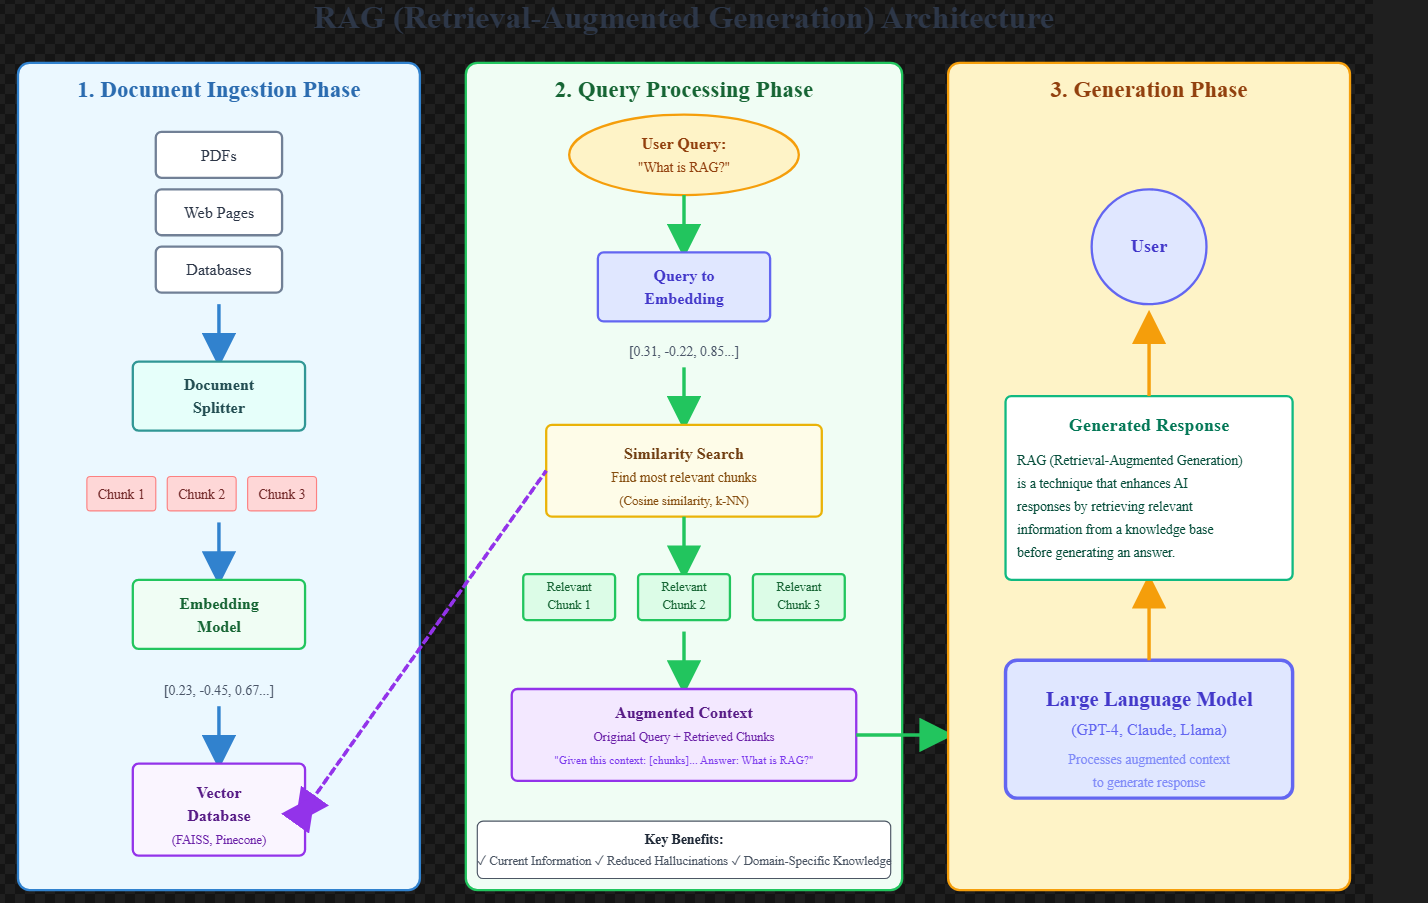

---